In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
import numpy as np
import itertools
import os

## Qutrit Gates

In [17]:
def x1_qutrit(q0, q1):
    """Applies X1 gate to a qutrit encoded in qubits (q0, q1)."""
    qc = QuantumCircuit(2)
    
    # Swap 00->01, 01->10, 10->00
    # Efficient sequence using CX and X gates
    qc.cx(q1, q0)
    qc.cx(q0, q1)
    qc.x(q0)
    
    return qc

def x2_qutrit(q0, q1):
    """Applies X2 gate to a qutrit encoded in qubits (q0, q1)."""
    qc = QuantumCircuit(2)
    
    # Reverse X1 logic
    qc.x(q0)
    qc.cx(q0, q1)
    qc.cx(q1, q0)
    
    return qc

X = [x1_qutrit(0, 1).to_instruction(label='X1'), x2_qutrit(0, 1).to_instruction(label='X2')]

def z2_qutrit(q0, q1):
    """Z1: applies phase ω to |01⟩, ω² to |10⟩."""
    qc = QuantumCircuit(2)
    
    
    omega = np.exp(2j * np.pi / 3)
    qc.p(np.angle(omega), q1)       # |01⟩
    qc.p(np.angle(omega**2), q0)    # |10⟩
    
    return qc

def z1_qutrit(q0, q1):
    """Z1: applies phase ω to |01⟩, ω² to |10⟩."""
    qc = QuantumCircuit(2)

    omega = np.exp(2j * np.pi / 3)
    qc.p(np.angle(omega**2), q1)       # |01⟩
    qc.p(np.angle(omega), q0)    # |10⟩
    
    return qc

Z = [z1_qutrit(0, 1).to_instruction(label='Z1'), z2_qutrit(0, 1).to_instruction(label='Z2')]

## Qutrit Dense Coding

In [18]:
qc = QuantumCircuit(4)

val = 1/np.sqrt(3)  
omega = np.exp(2j * np.pi / 3)
hadamard = np.array([[val,val,val, 0],[val,val * omega**2, val * omega**4, 0], [1/np.sqrt(3), 1/np.sqrt(3)*omega, 1/np.sqrt(3)*omega**2, 0], [0,0,0,1]], dtype=complex)
trit_hadamard_gate = UnitaryGate(hadamard, label='qutrit_hadamard')

qc.initialize([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3), 0], [0, 1])  # Alice’s qutrit
qc.cx(0, 2)
qc.cx(1, 3)

qc.barrier()
#qc.append(Z[0], [0, 1])
qc.append(Z[1], [0, 1])
#qc.append(X[0], [0, 1])
qc.append(X[1], [0, 1])
qc.barrier()

qc.cx(0,2)
qc.ccx(0,2,3)
qc.ccx(0,3,2)
qc.cx(1,3)
qc.ccx(1,3,2)
qc.ccx(1,2,3)
qc.append(trit_hadamard_gate, [0, 1])

qc.measure_all()

## Measurements

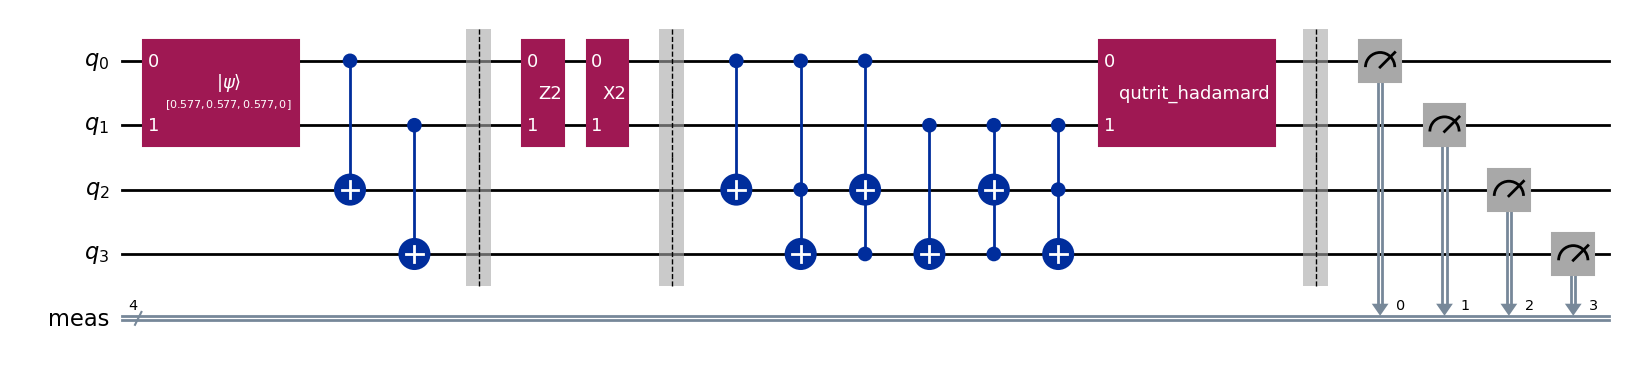

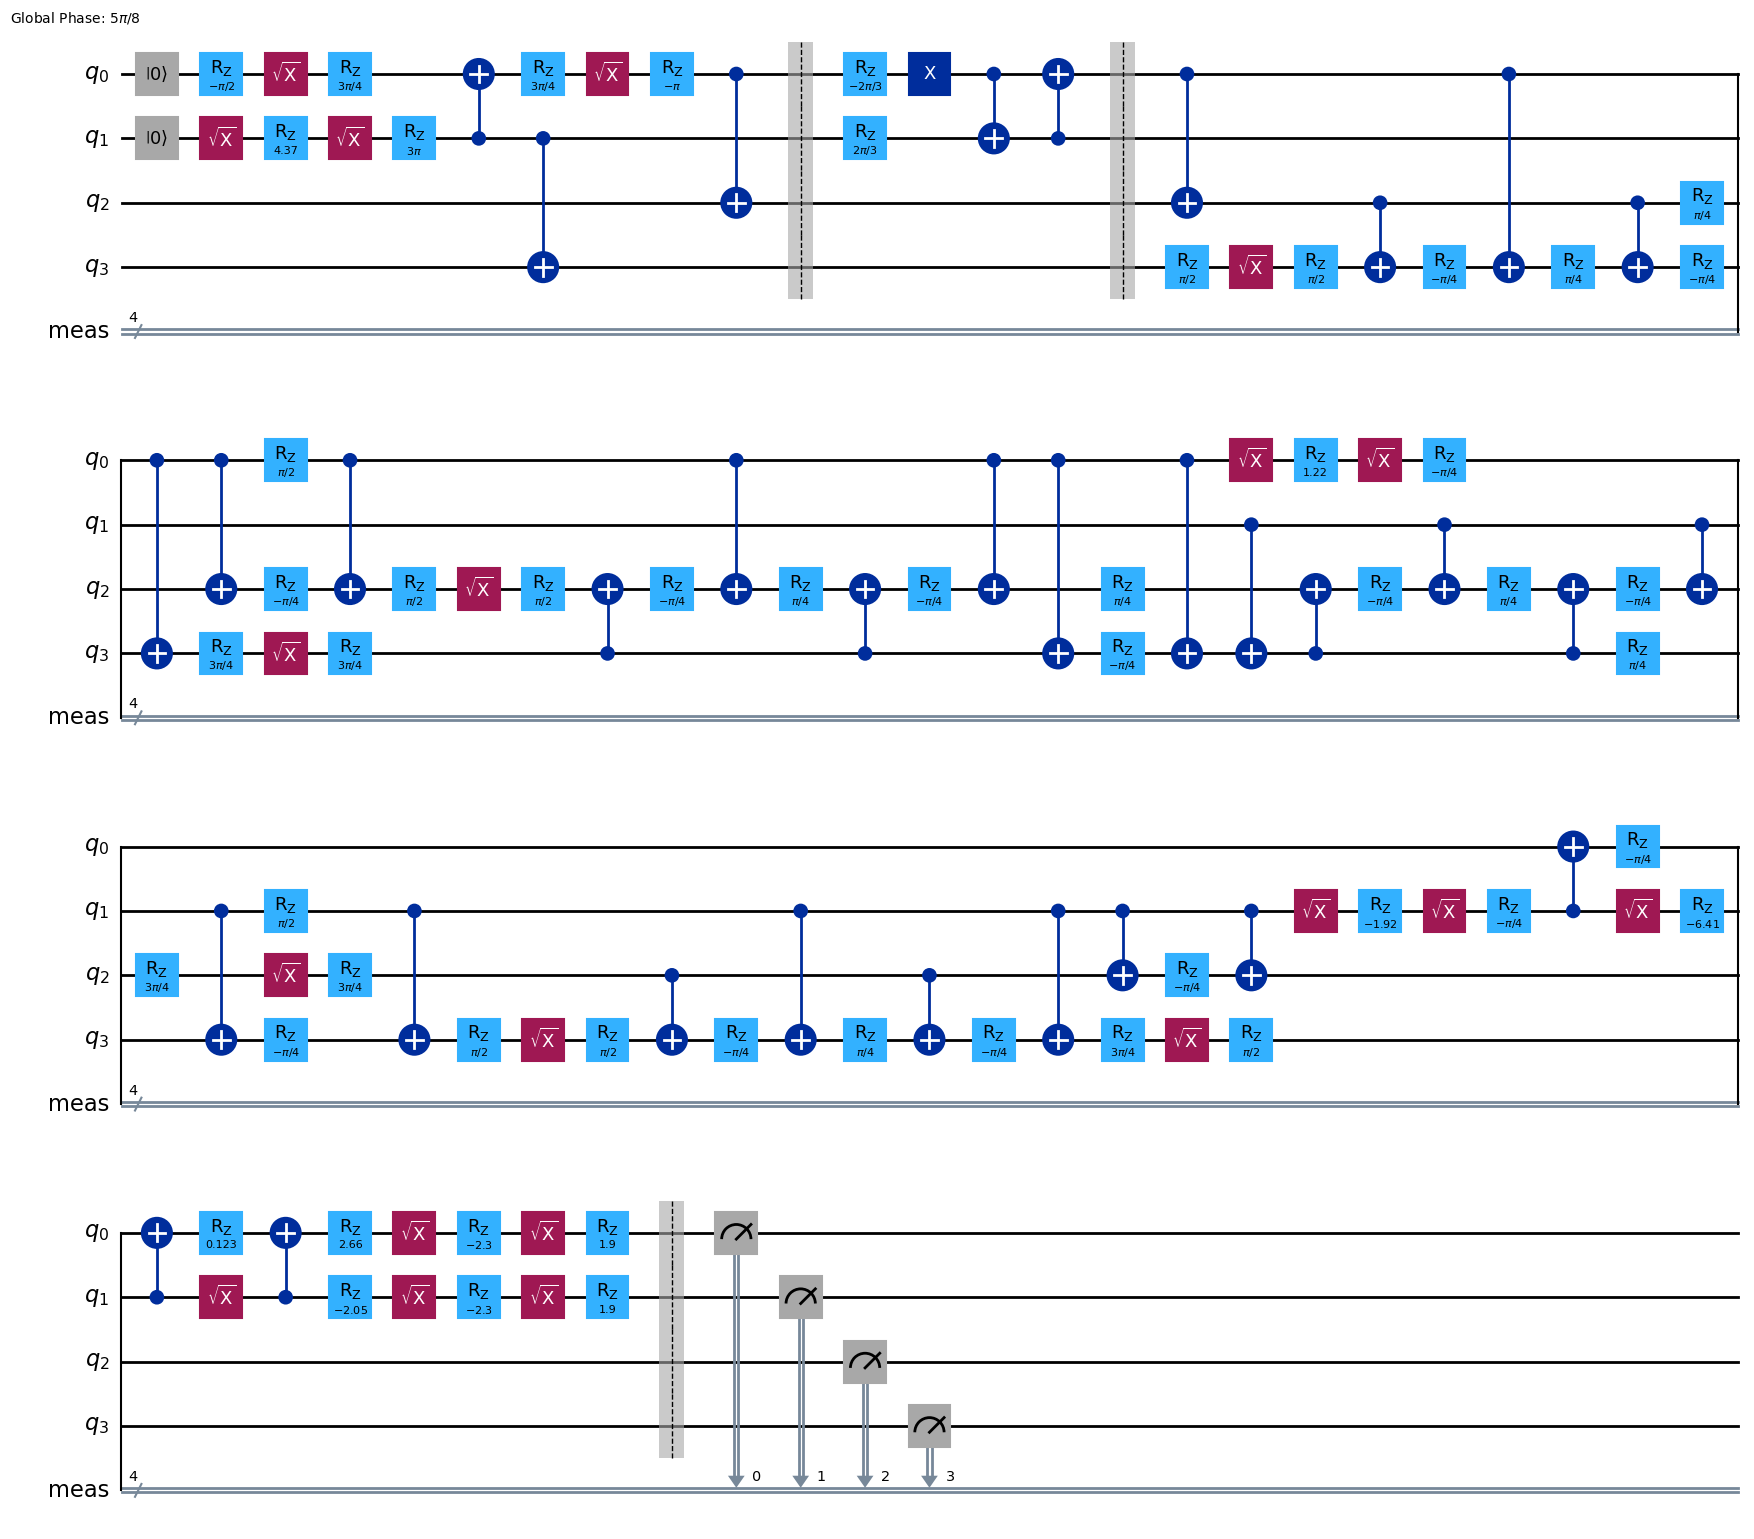

OrderedDict([('rz', 54), ('cx', 34), ('sx', 20), ('measure', 4), ('barrier', 3), ('reset', 2), ('x', 1)])
80


In [19]:
display(qc.draw('mpl'))

transpiled = transpile(qc, basis_gates=['rz', 'sx', 'x', 'cx'], optimization_level=3)
display(transpiled.draw('mpl'))
print(transpiled.count_ops())
print(transpiled.depth())

Measurement Counts: {'0110': 10000}


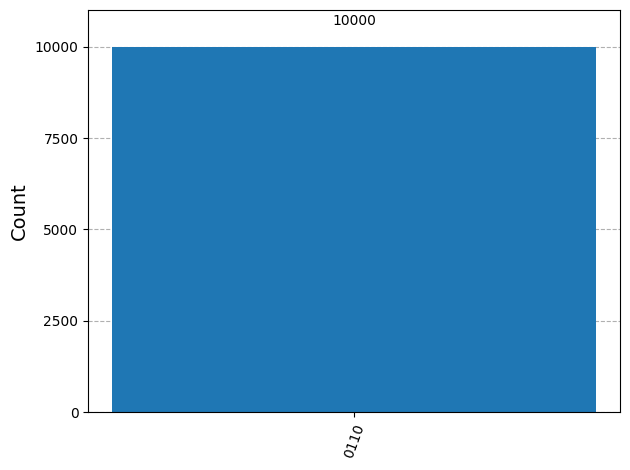

In [20]:
sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=10000).result()
counts = result.get_counts()

# Show results
print("Measurement Counts:", counts)
plot_histogram(counts)

## Run on Hardware

In [21]:
your_api_key = os.getenv("API_KEY_IBM")  #API Key Here
your_crn = os.getenv("CRN_IMB")          #CRN Here

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
)

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()
# Get a backend
backend = service.least_busy(operational=True, simulator=False)
print(f"We are using the {backend.name} quantum computer")
from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager

service = QiskitRuntimeService(name="qgss-2025")

sampler = Sampler(mode=backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)


job = sampler.run(pm.run([qc2]), shots=10000)

results_sampler = job.result()

counts =results_sampler[0].data.meas.get_counts()
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the histogram
plot_histogram(
        counts,
        title='Dense Coding Qubit Qubit',
        color='midnightblue',
        ax=ax
)
    
    # Add custom axis labels
ax.set_xlabel('Messages')
ax.set_ylabel('Counts')
    
    # Display the plot
plt.tight_layout()
display(fig)

InvalidAccountError: "Invalid `token` value. Expected a non-empty string, got 'None'."